In [47]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [168]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta #adding this to use months instead of days, found it on google 
#https://renanmf.com/how-to-subtract-months-from-a-date-in-python/#:~:text=The%20easiest%20way%20to%20subtract,to%20use%20the%20dateutil%20extension.&text=The%20relativedelta%20object%20from%20the,months%20from%20a%20date%20object.

# Reflect Tables into SQLAlchemy ORM

In [49]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect #adding inspector

In [50]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [51]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [52]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [53]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [54]:
# Create our session (link) from Python to the DB
sesh = Session(engine)

In [135]:
# Inspecting columns swap: Measurement/Station
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for whatever in columns:
    print(whatever['name'], whatever["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [56]:
# Find the most recent date in the data set.
last_date = sesh.query(measurement.date).order_by(measurement.date.desc()).first()
print(last_date.date)

2017-08-23


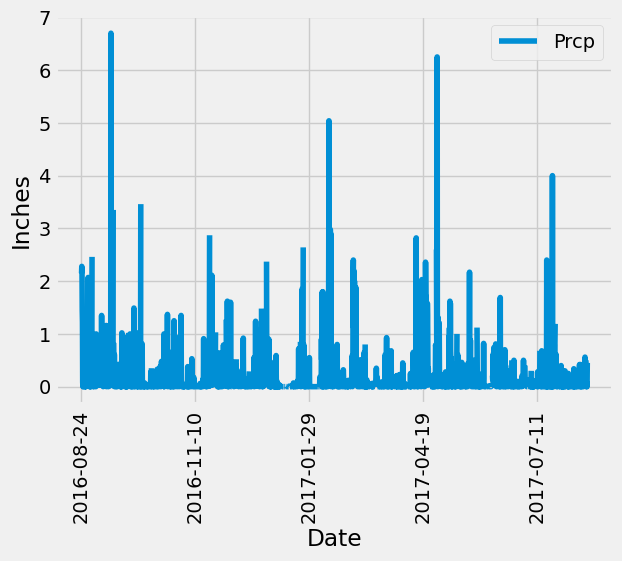

In [127]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.datetime.strptime(last_date.date, '%Y-%m-%d') - relativedelta(months=12)
# print(year_ago.date)

# Perform a query to retrieve the data and precipitation scores
precip_query = sesh.query(measurement.date, measurement.prcp).filter(measurement.date >= year_ago).all()
#precip_query

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_query, columns=['Date', 'Prcp'])
precip_df.set_index(precip_df['Date'], inplace=True)

# Sort the dataframe by date
precip_df = precip_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()
plt.xticks(rotation=90)
plt.ylabel('Inches')
plt.show()

In [128]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [134]:
# Design a query to calculate the total number of stations in the dataset
station_ct = sesh.query(func.count(station.id)).all()
station_ct

[(9,)]

In [151]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_q = sesh.query(measurement.station, func.count(measurement.station))\
            .group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
station_q

active_stat = sesh.query(measurement.station, func.count(measurement.station))\
            .group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()
active_stat.station

'USC00519281'

In [155]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_deets = sesh.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs))\
                .filter(measurement.station == active_stat.station).all()
station_deets

[(54.0, 85.0, 71.66378066378067)]

<Axes: ylabel='Frequency'>

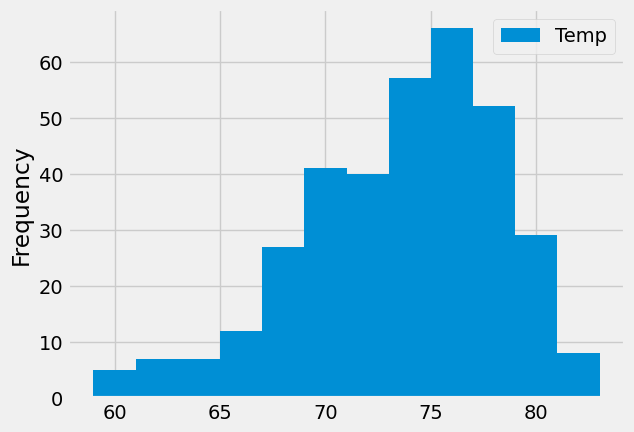

In [165]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_query = sesh.query(measurement.date, measurement.tobs)\
            .filter(measurement.date >= year_ago, measurement.station == active_stat.station).all()
temp_df = pd.DataFrame(temp_query, columns=['Date', 'Temp'])
temp_df.plot.hist(bins=12)

# Close Session

In [167]:
# Close Session
sesh.close()